# Prototype 2 > Experiment 1

## --- Dependencies ---

In [1]:
# Standard Dependencies
import sys
import os
import numpy as np
from tabulate import tabulate
import torch
from time import time
import torch.nn as nn

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Dependencies
from src.autoencoder import AutoEncoder, RMSELoss
from src.custom_types import Behavior, Execution, Evaluation, MTDTechnique, actions, mitigated_by
from src.data_provider import DataProvider
from src.functions import split_training_data, split_data, calculate_balance_metrics, run_sample_distribution_experiment, show_number_of_attack_samples_used, experiment_show_performance_evaluations
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

In [3]:
from src.environment import Environment
from src.deep_q_network import DeepQNetwork
from src.agent import Agent
from src.client import Client
from src.server import Server
from src.experiment import Experiment

In [4]:
rl_training_data, test_data, _ = DataProvider.get_scaled_train_test_split_one(scaling_minmax=True, scale_normal_only=True)
normal_data = rl_training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

rl_training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

rl_training_data_strides = split_training_data(rl_training_data, 10)

In [5]:
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, rl_training_data, n_hidden_1=64, n_hidden_2=16, activation_function=nn.GELU())
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=50, batch_size=64, verbose=False)

In [6]:
autoencoder.evaluate(n_std=5, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 90.36\%    & \notCalculated & \notCalculated & \notCalculated &        4118 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        5314 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2599 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3823 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4107 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2077 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3050 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2127 \\

---
## Experiment 2.1.1 (Centralized Baseline)
Centralized Learning on 1 Client with blanced Attack Probabilities

In [7]:
p2e1v1 = run_sample_distribution_experiment([rl_training_data], test_data, unit_sampling_probabilities, unit_sampling_probabilities, autoencoder, 30, 100, False)



Dataset Balance Metrics: MID=0.0 & WCS=1.0
Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.05 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      10.36 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |       0.41 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |       0    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |       0    | MTD

In [8]:
experiment_show_performance_evaluations(p2e1v1)

>>> Performance Evluations of Global Agent over all FL Training Rounds <<<

- Global Agent (Rounds): dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

- Global Agent (Micro Accuracies): [0.261136712749616, 0.7415941286909029, 0.977299880525687, 0.9704727769243898, 0.9813961426864652, 0.9941116231438812, 0.9925755248335894, 0.9921488308585082, 0.9891619730329407, 0.9924901860385731, 0.9930875576036866, 0.9847243556920976, 0.9882232462877624, 0.988479262672811, 0.9911247653183137, 0.9897593445980543, 0.9915514592933948, 0.9931728963987029, 0.9912954429083461, 0.9871991807475679, 0.9895886670080218, 0.989247311827957, 0.9859190988223246, 0.9865164703874382, 0.9889912954429083, 0.9858337600273084, 0.986857825567503, 0.9891619730329407, 0.9879672299027138, 0.9890766342379246, 0.989247311827957]

- Global Agent (Macro Accuracies):: [0.13919976035858744, 0.7746522652881066, 0.9712620932678824, 0.9688061627709846, 0.9

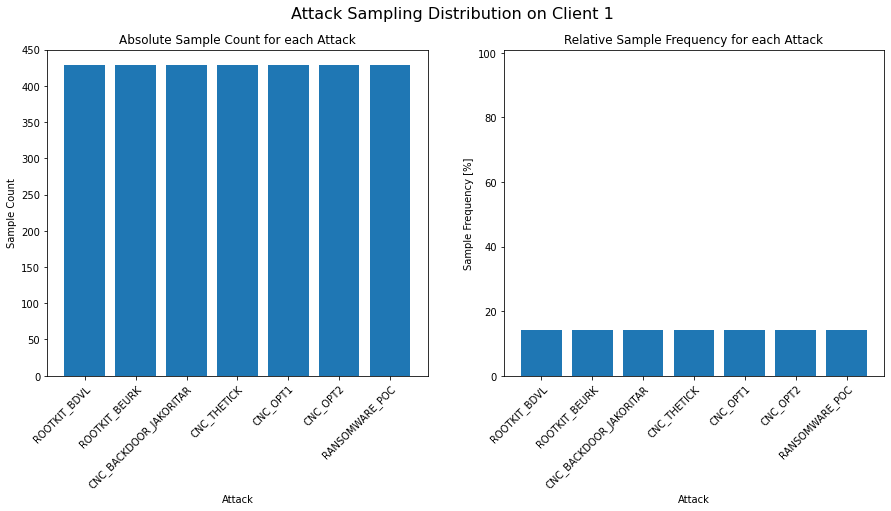

In [14]:
p2e1v1.plot_sampling_distributions()

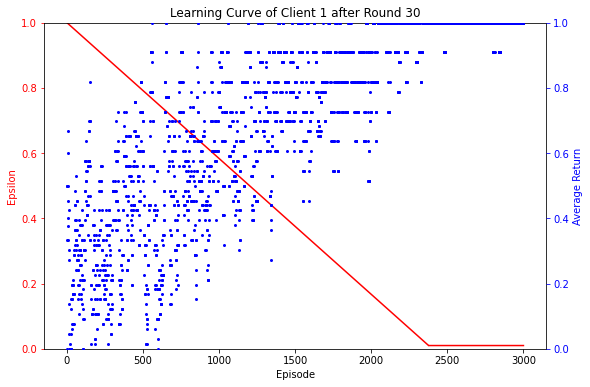

In [15]:
p2e1v1.show_learning_curves()

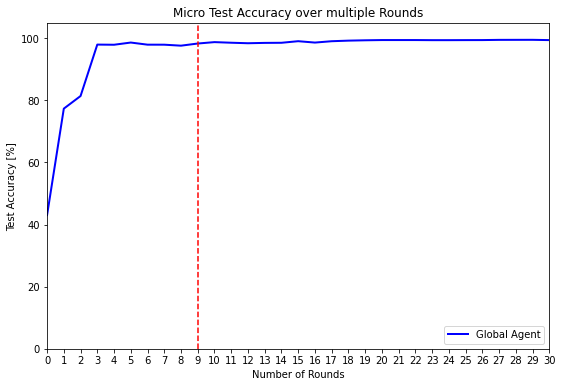

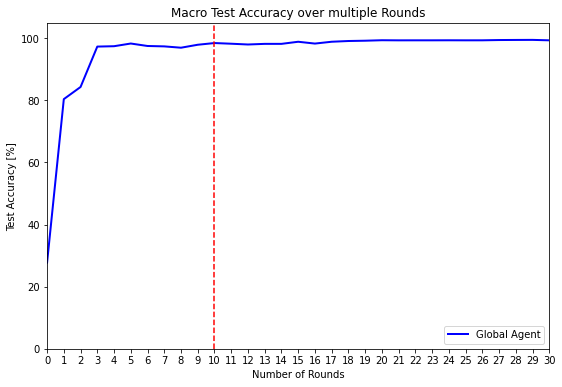

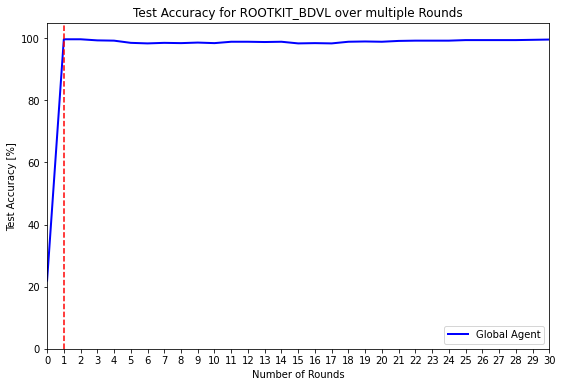

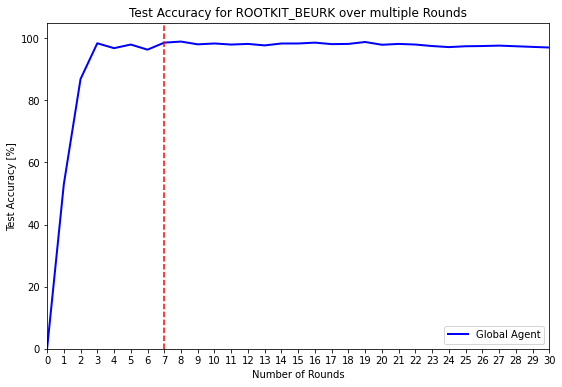

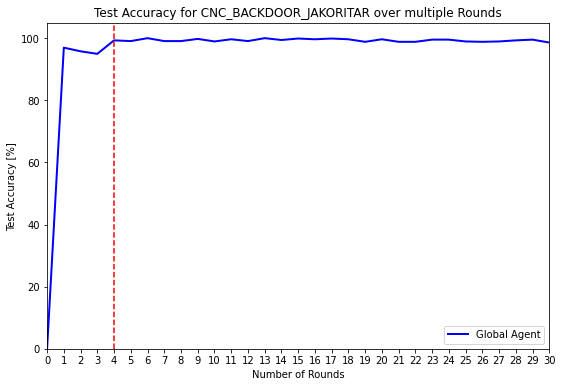

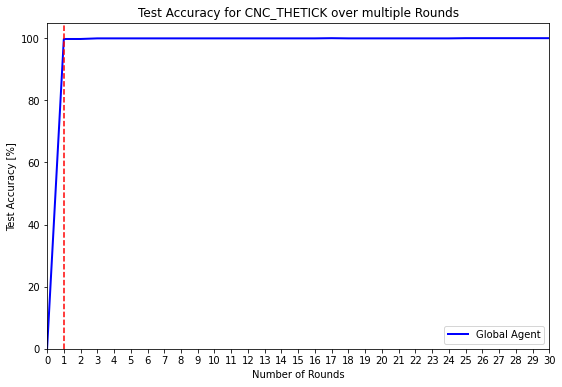

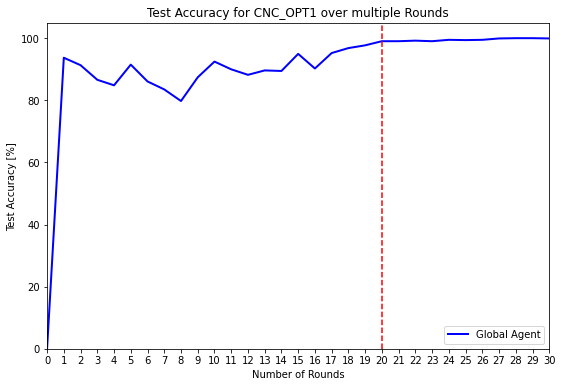

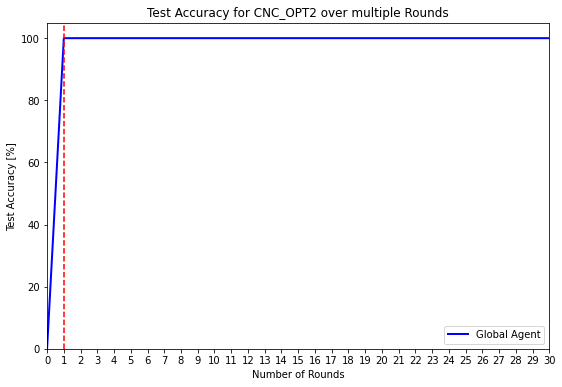

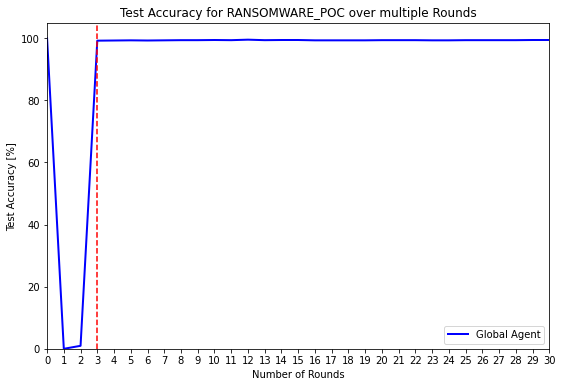

In [47]:
p2e1v1.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=False)

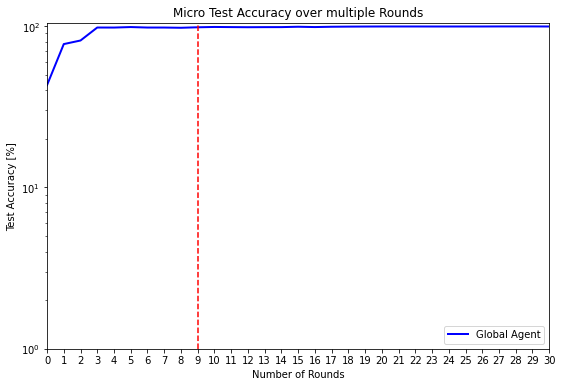

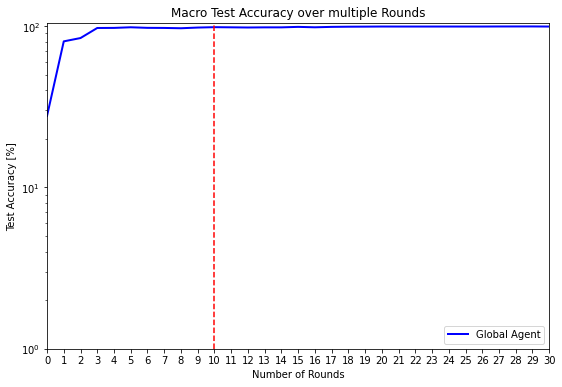

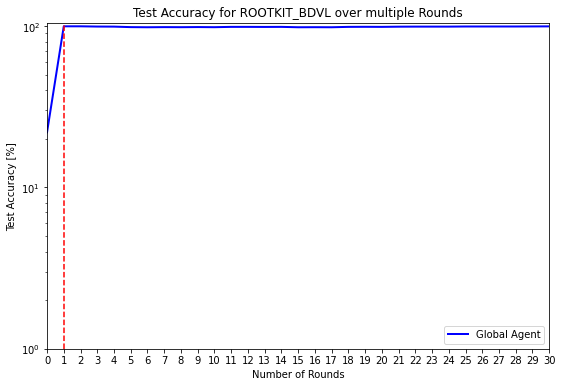

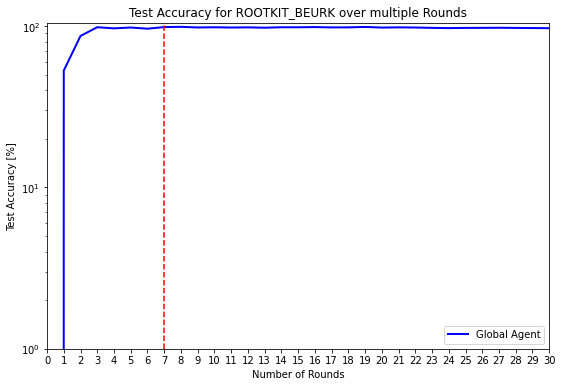

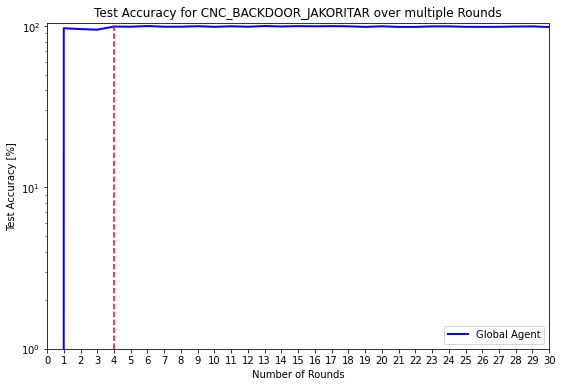

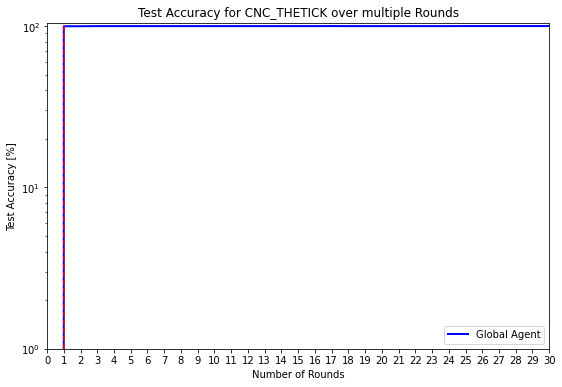

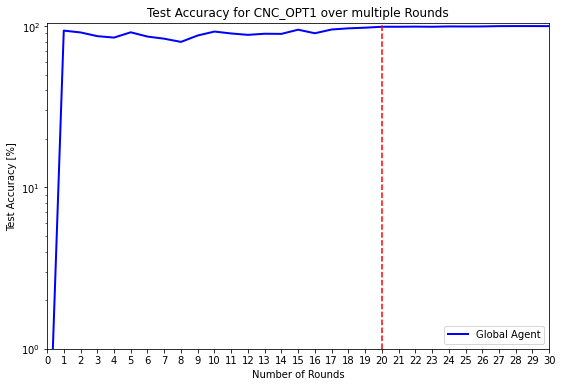

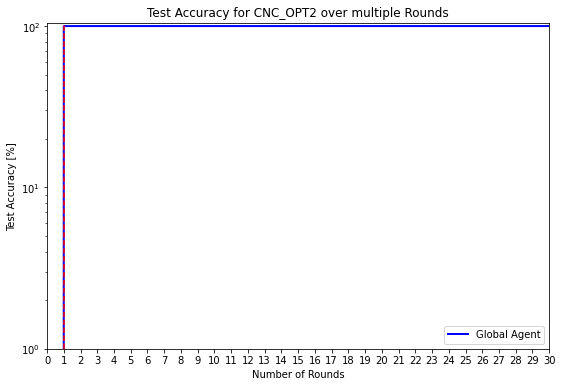

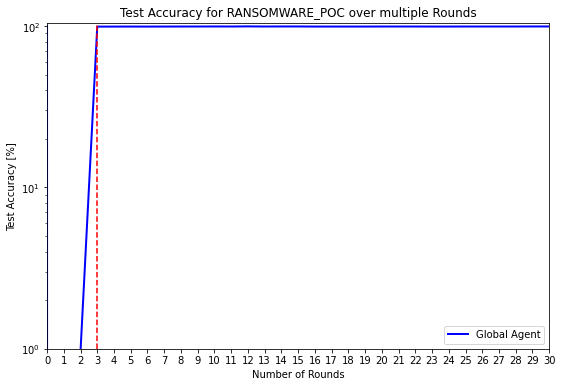

In [48]:
p2e1v1.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=True)

---
## Experiment 2.1.2 (Federated Baseline)
Federated Learning with 10 Clients with globally and locally class balanced Attack Probabilities


In [7]:
show_number_of_attack_samples_used(unit_sampling_probabilities, unit_sampling_probabilities, 3000)

=== Absolute Number of Attack Samples used ===

--- For Clients with even ID ---
Behavior.ROOTKIT_BDVL: 428
Behavior.ROOTKIT_BEURK: 428
Behavior.CNC_BACKDOOR_JAKORITAR: 428
Behavior.CNC_THETICK: 428
Behavior.CNC_OPT1: 428
Behavior.CNC_OPT2: 428
Behavior.RANSOMWARE_POC: 428

--- For Clients with uneven ID ---
Behavior.ROOTKIT_BDVL: 428
Behavior.ROOTKIT_BEURK: 428
Behavior.CNC_BACKDOOR_JAKORITAR: 428
Behavior.CNC_THETICK: 428
Behavior.CNC_OPT1: 428
Behavior.CNC_OPT2: 428
Behavior.RANSOMWARE_POC: 428


In [ ]:
p2e1v2 = run_sample_distribution_experiment(rl_training_data_strides, test_data, unit_sampling_probabilities, unit_sampling_probabilities, autoencoder, 30, 100, True)


In [31]:
experiment_show_performance_evaluations(p2e1v2)

>>> Performance Evluations of Agent 1 over all FL Training Rounds <<<

- Agent 1 (Rounds): dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

- Agent 1 (Micro Accuracies): [0.5034135518006486, 0.7902372418501451, 0.855094726062468, 0.985236388462195, 0.9811401263014167, 0.9539170506912442, 0.9731182795698925, 0.973715651135006, 0.9658644819935143, 0.9683393070489845, 0.974142345110087, 0.9779825908858167, 0.9537463731012118, 0.9673152415087899, 0.9476873186550606, 0.9468339307048984, 0.9743130227001194, 0.9552824714115037, 0.9703874381293736, 0.9759344598054276, 0.9438470728793309, 0.9711554872845195, 0.9897593445980543, 0.9706434545144222, 0.9819935142515788, 0.9836149513568868, 0.9887352790578597, 0.987284519542584, 0.9740570063150709, 0.9662911759685954, 0.9553678102065198]

- Agent 1 (Macro Accuracies):: [0.3722396517252608, 0.8183154237561412, 0.8775357004678288, 0.9805052444555129, 0.9801279182753029, 0.9

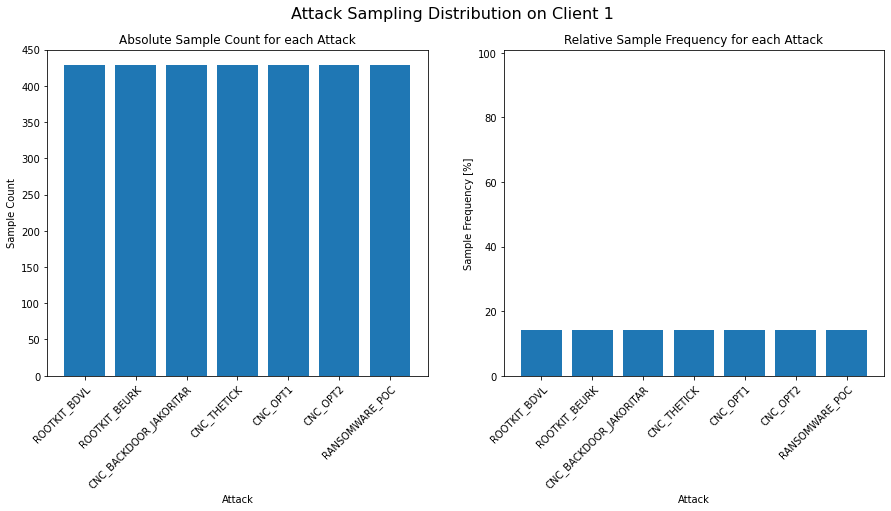

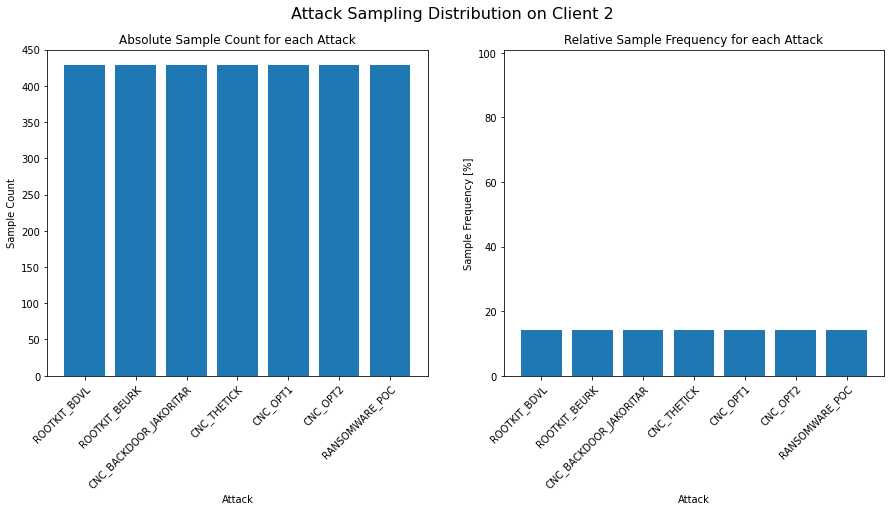

In [32]:
p2e1v2.plot_sampling_distributions()

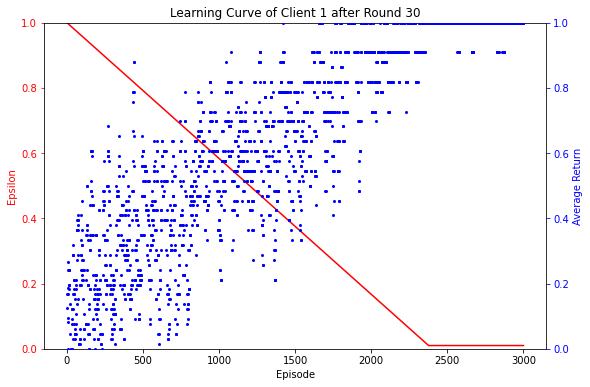

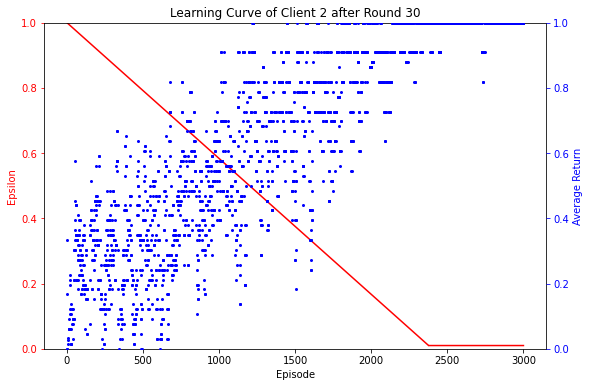

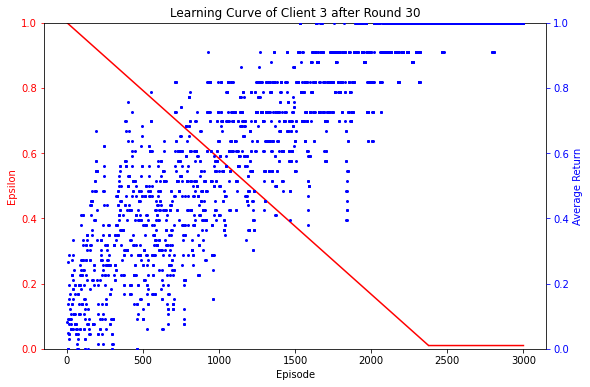

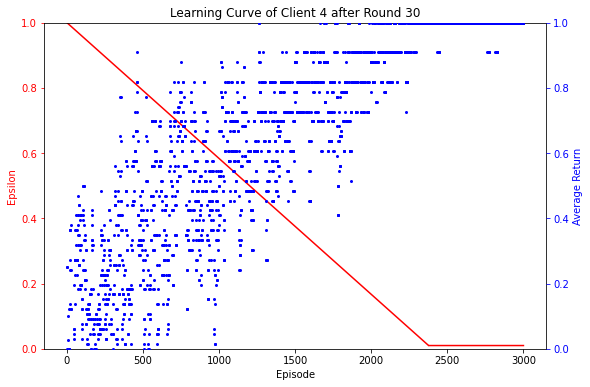

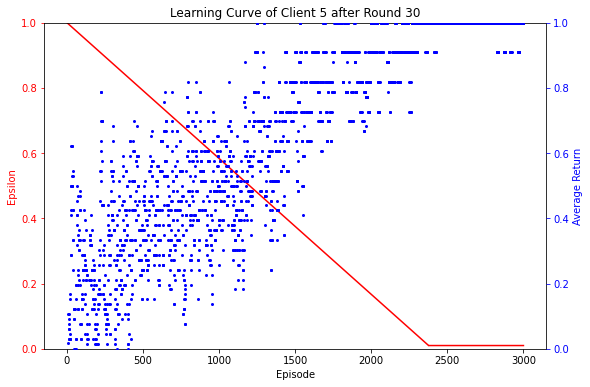

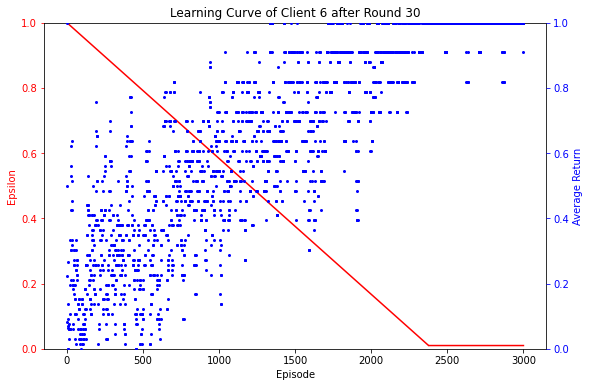

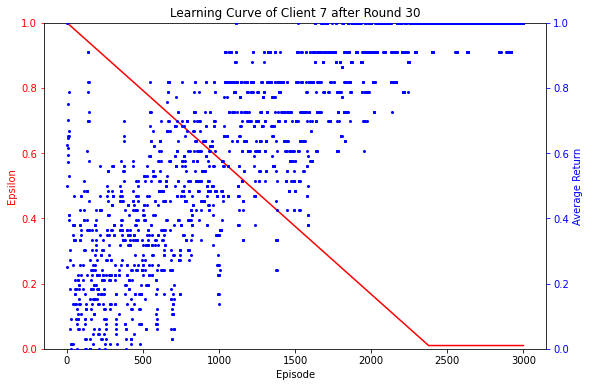

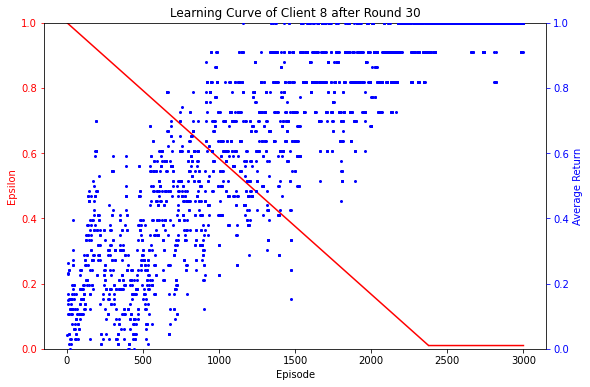

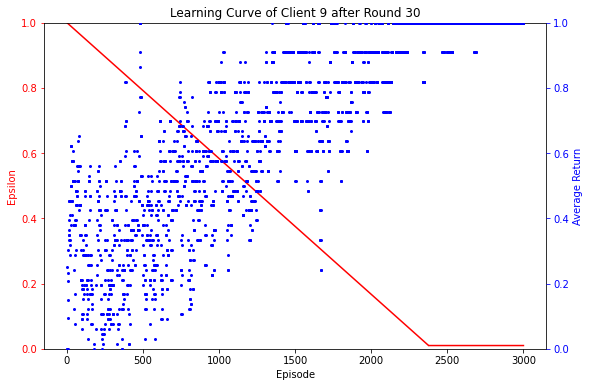

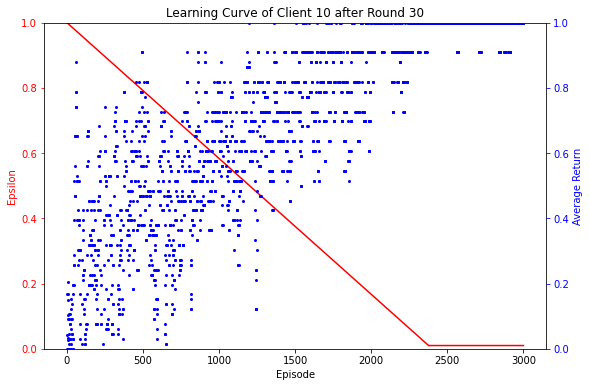

In [33]:
p2e1v2.show_learning_curves()

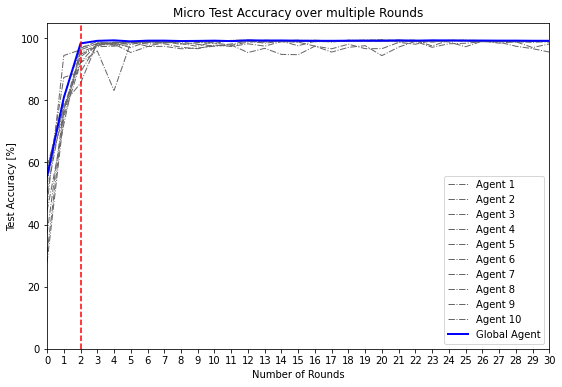

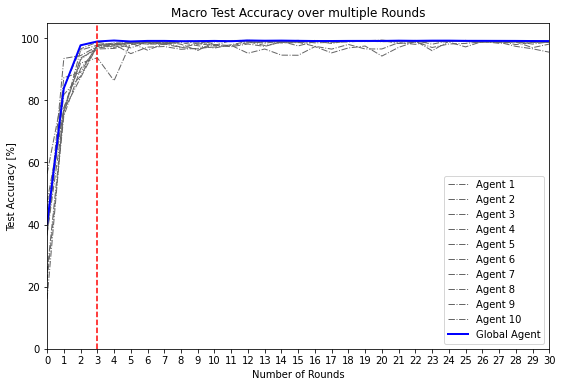

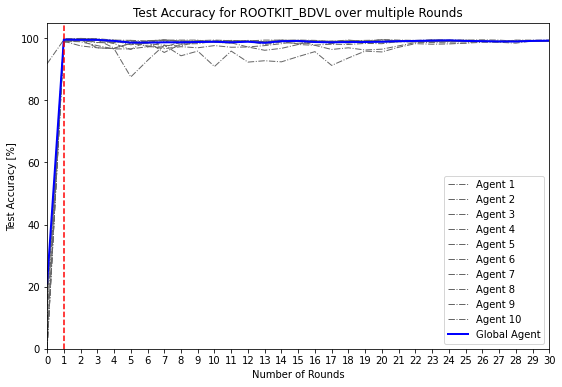

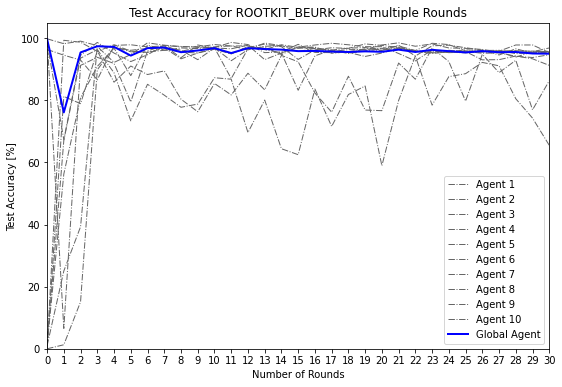

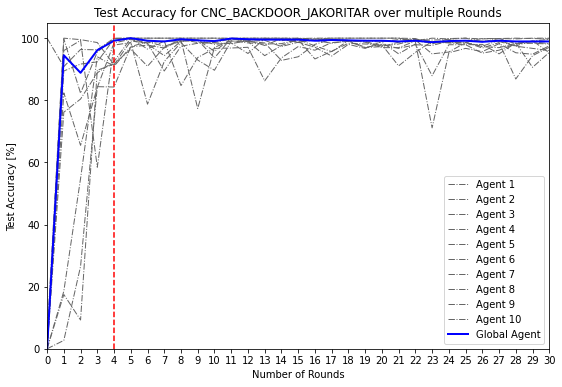

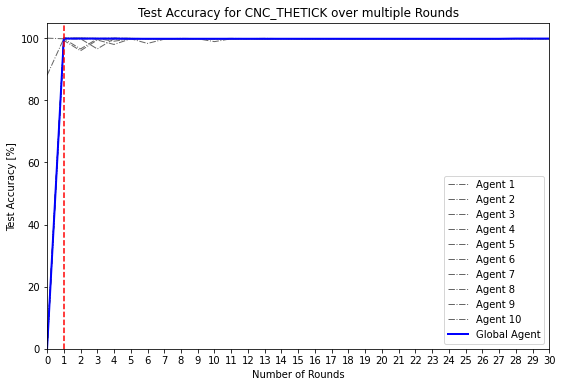

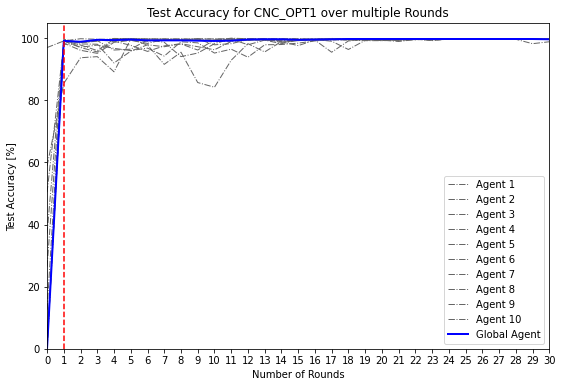

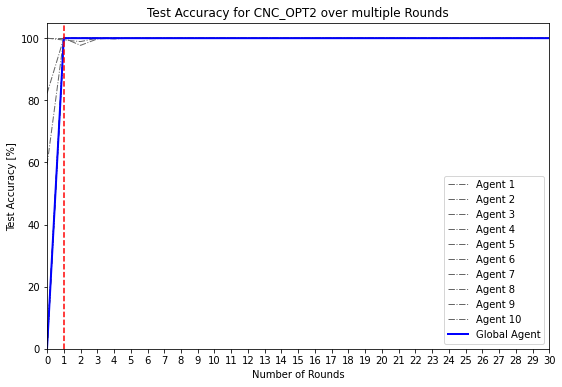

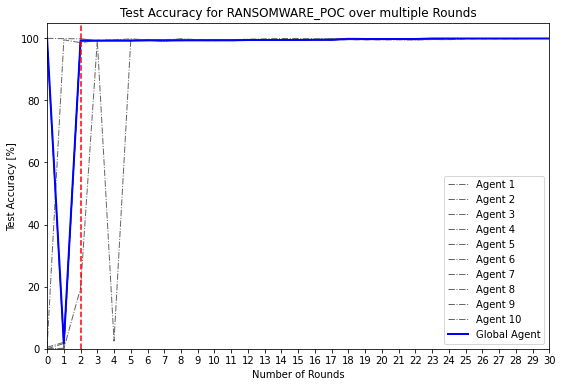

In [34]:
p2e1v2.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=False)

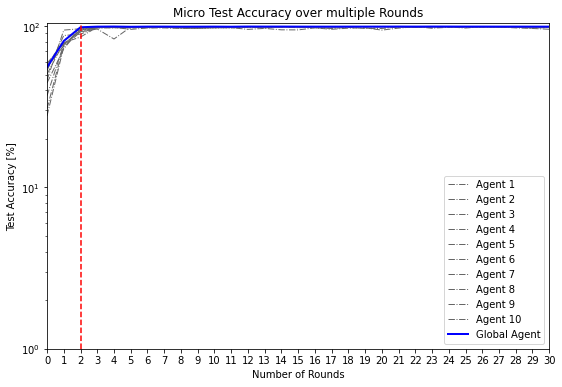

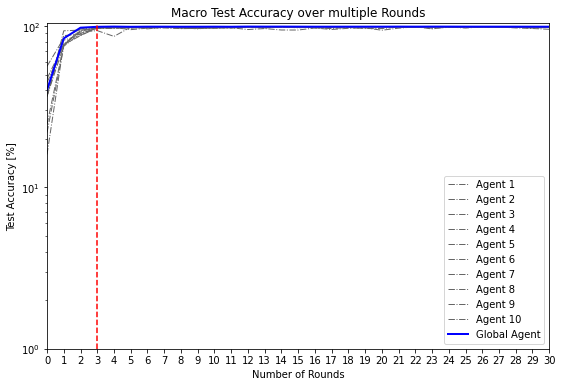

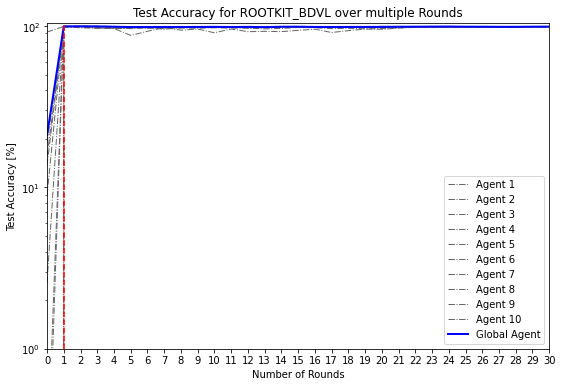

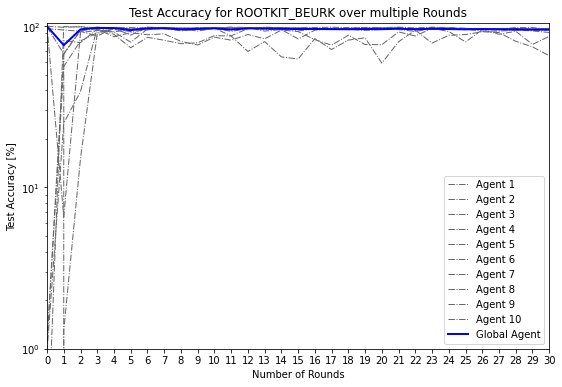

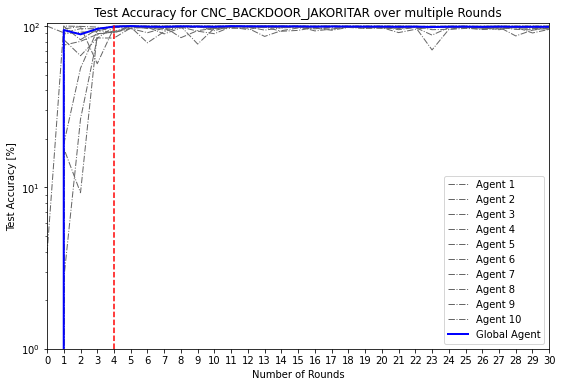

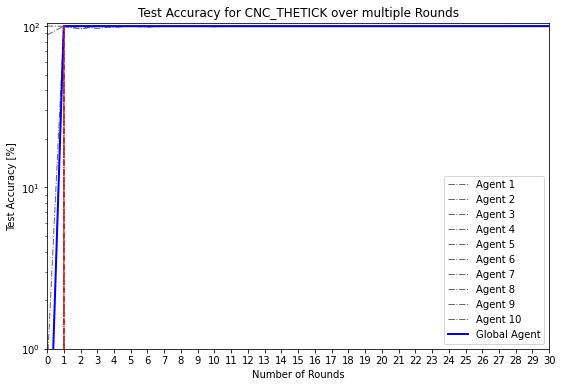

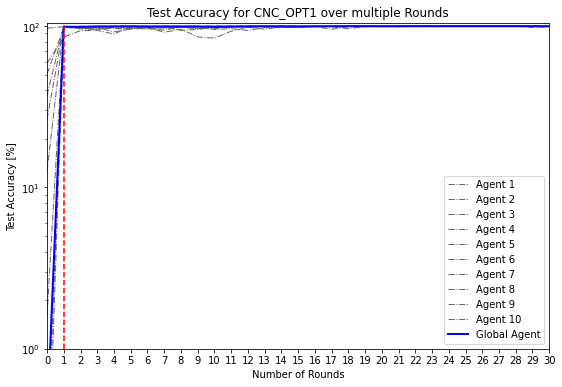

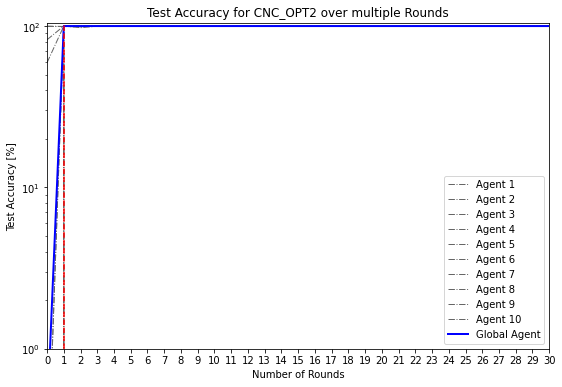

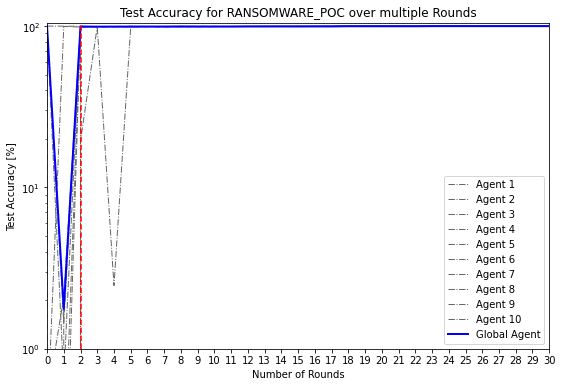

In [35]:
p2e1v2.show_experiment_graphs(y_threshold=98, show_individual_clients=True, y_log_scale=True)

In [ ]:
p2e1v2.server